### Routine to train and fine-tune Catboost Binary Classifier

##### TODOs:
- Set MlFlow tracking URI
- Start mlflow server: mlflow server --host 127.0.0.1 --port 8080 (LOCAL)
- Change folders if needee

In [1]:
# ! mlflow server --host 127.0.0.1 --port 8080

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, 
                                   StratifiedKFold, cross_val_score)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_curve, auc, precision_recall_curve,
                           average_precision_score, confusion_matrix, 
                           classification_report)
from scipy.stats import randint, uniform, loguniform
import joblib
import pickle
import os
from datetime import datetime
import json

# MLflow imports
import mlflow
import mlflow.catboost
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import multiprocessing

from typing import Tuple, Optional, Union, List, Dict
from pathlib import Path
from dataclasses import dataclass, field

In [3]:
# Set MlFlow tracking URI
mlflow.set_tracking_uri("http://localhost:8080")  # Check your MLflow server URI

In [4]:
@dataclass
class SampleConfig:
    """Sample configuration."""
    name: str
    n_samples_per_class: int
    random_state: int = 42

@dataclass
class DatasetInfo:
    n_samples: int
    n_features: int
    class_distribution: Dict[int, int]
    features_columns: List[str]
    labels_columns: List[str]

@dataclass
class DataLoader:
    features_path: Union[str, Path]
    labels_path: Union[str, Path]
    _features_df_cache: Optional[pd.DataFrame] = field(default=None, init=False, repr=False)
    _labels_df_cache: Optional[pd.DataFrame] = field(default=None, init=False, repr=False)

    def __post_init__(self):
        self.features_path = Path(self.features_path)
        self.labels_path = Path(self.labels_path)

        if not self.features_path.exists():
            raise FileNotFoundError(f"Features file not found: {self.features_path}")
        if not self.labels_path.exists():
            raise FileNotFoundError(f"Labels file not found: {self.labels_path}")

    def load_full_data(self, use_cache: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
        
        if use_cache and self._features_df_cache is not None and self._labels_df_cache is not None:
            return self._features_df_cache, self._labels_df_cache

        features_df = pd.read_parquet(self.features_path)
        labels_df = pd.read_parquet(self.labels_path)

        # Dimensions check
        if len(features_df) != len(labels_df):
            raise ValueError(f"Features and labels have different lengths: "
                           f"{len(features_df)} vs {len(labels_df)}")

        if use_cache:
            self._features_df_cache = features_df
            self._labels_df_cache = labels_df

        return features_df, labels_df
    
    @staticmethod
    def clear_cache(self) -> None:
        self._features_df_cache = None
        self._labels_df_cache = None

    def load_balanced_sample(self, 
                            n_samples_per_class: int, 
                            random_state: int = 42,
                            use_cache: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
        
        # Load full data (with caching option)
        features_df_full, labels_df_full = self.load_full_data(use_cache=use_cache)

        # Get sampled indices balanced across classes
        sampled_indices = self._get_balanced_indices(
            labels_df_full = labels_df_full,
            n_samples_per_class = n_samples_per_class,
            random_state =random_state
        )
        features_df = features_df_full.loc[sampled_indices].reset_index(drop=True)
        labels_df = labels_df_full.loc[sampled_indices].reset_index(drop=True)

        return features_df, labels_df

    def load_balanced_sample_memory_efficient(self, n_samples_per_class: int, 
                                            random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
        
        features_df_full = pd.read_parquet(self.features_path)
        labels_df_full = pd.read_parquet(self.labels_path)

        # Get sampled indices balanced across classes
        sampled_indices = self._get_balanced_indices(
            labels_df = labels_df_full, 
            n_samples_per_class = n_samples_per_class, 
            random_state = random_state
        )

        features_df = features_df_full.loc[sampled_indices].reset_index(drop=True)
        labels_df = labels_df_full.loc[sampled_indices].reset_index(drop=True)

        # Clean up memory
        del features_df_full, labels_df_full, sampled_indices

        return features_df, labels_df
    
    def _get_balanced_indices(self, labels_df: pd.DataFrame, 
                            n_samples_per_class: int, 
                            random_state: int = 42) -> pd.Index:
        """
        Get indices of a balanced sample from the labels DataFrame.
        """
        label_column = labels_df.iloc[:, 0]

        # Check if all classes have enough samples
        class_counts = label_column.value_counts()
        for class_label, count in class_counts.items():
            if count < n_samples_per_class:
                raise ValueError(f"Class {class_label} has only {count} samples, "
                               f"but {n_samples_per_class} requested")

        sampled_indices = (
            labels_df.groupby(label_column)
            .apply(lambda x: x.sample(n=n_samples_per_class, random_state=random_state))
            .index.get_level_values(1)
        )
        return sampled_indices

### Training
#### Load a smaller balanced dataset for hyperparameter tuning and a larger one for final retraining with optimal parameters

In [5]:
# Carico un dataset più piccolo a classi bilanciate per la ricerca degli iperparametri 
# e uno più esteso per ri-trainare il modello con i parametri ottimali trovati

loader = DataLoader(
    features_path='processed_data/binary_classification/data_w_features/combined_features.parquet',
    labels_path='processed_data/binary_classification/data_w_features/labels_binary.parquet'
)

# Esempio 1: Carica 40k campioni bilanciati (20k per classe) per training
features_df, labels_df = loader.load_balanced_sample_memory_efficient(n_samples_per_class=25000)
print(f"Training set shape: features={features_df.shape}, labels={labels_df.shape}")

# Esempio 2: Carica 500k campioni bilanciati (250k per classe) per fit finale
features_df_to_finalize, labels_df_to_finalize = loader.load_balanced_sample_memory_efficient(
    n_samples_per_class=250000
)
print(f"Final set shape: features={features_df_to_finalize.shape}, labels={labels_df_to_finalize.shape}")
print(f"Class distribution in dev set set: {labels_df.iloc[:, 0].value_counts()}")
print(f"Class distribution in final set: {labels_df_to_finalize.iloc[:, 0].value_counts()}")

Training set shape: features=(50000, 134), labels=(50000, 1)
Final set shape: features=(500000, 134), labels=(500000, 1)
Class distribution in dev set set: 0
0    25000
1    25000
Name: count, dtype: int64
Class distribution in final set: 0
0    250000
1    250000
Name: count, dtype: int64


### Ricerca iperparametri e training del modello


In [ ]:
class CatBoostPipeline:
    def __init__(self, features_df, labels_df, test_size=0.2, random_state=42,
                 experiment_name="catboost_binary_classification", model_save_dir="./models"):
        
        self.features_df = features_df
        self.labels_df = labels_df.values.ravel() if isinstance(labels_df, pd.DataFrame) else labels_df
        self.test_size = test_size
        self.random_state = random_state
        self.model = None
        self.best_params = None
        self.cv_results = None
        self.scaler = None
        
        # MLflow setup
        self.experiment_name = experiment_name
        self.model_save_dir = model_save_dir
        self.run_id = None
        
        # Create output directory if it doesn't exist
        os.makedirs(model_save_dir, exist_ok=True)
        
        # Setup MLflow experiment
        self._setup_mlflow_experiment()
 
    def _setup_mlflow_experiment(self):
        
        try:
            
            experiment = mlflow.get_experiment_by_name(self.experiment_name)
            if experiment is None:
                mlflow.create_experiment(self.experiment_name)
            
            mlflow.set_experiment(self.experiment_name)
            print(f"MLflow experiment '{self.experiment_name}' correctly set up.")
            
        except Exception as e:
            print(f"Error in mlflow configuration: {e}")
    
    def _log_to_mlflow(self, key, value):
        """Helper per logging sicuro su MLflow"""
        try:
            if isinstance(value, (int, float)):
                mlflow.log_metric(key, value)
            else:
                mlflow.log_param(key, value)
        except Exception as e:
            print(f"⚠️  Errore nel logging MLflow per {key}: {e}")

           
    def prepare_data(self):
        """Split data into train and test sets"""
        print("=== Data preparation ===")
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.features_df, self.labels_df, 
            test_size=self.test_size, 
            random_state=self.random_state,
            stratify=self.labels_df
        )
        
        # Features scaling
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Log info dataset su MLflow
        try:
            mlflow.log_param("dataset_total_samples", len(self.features_df))
            mlflow.log_param("train_samples", self.X_train.shape[0])
            mlflow.log_param("test_samples", self.X_test.shape[0])
            mlflow.log_param("n_features", self.X_train.shape[1])
            mlflow.log_param("test_size", self.test_size)
            mlflow.log_param("random_state", self.random_state)
            
            class_distribution = pd.Series(self.y_train).value_counts(normalize=True)
            for class_label, proportion in class_distribution.items():
                mlflow.log_metric(f"class_{class_label}_proportion", proportion)
                
        except Exception as e:
            print(f"Error mlflow: {e}")
        
        print("Dataset dimensions:")
        print(f"Train set: {self.X_train.shape[0]} campioni")
        print(f"Test set: {self.X_test.shape[0]} campioni")
        print(f"Features: {self.X_train.shape[1]}")
        print("\nClass distribution:")
        print(pd.Series(self.y_train).value_counts(normalize=True))
        
    def hyperparameter_tuning(self, cv_folds=5, verbose=True, n_iter=250):
        print("\n=== HYPERPARAMETER TUNING ===")
        
        self.param_distributions = {
            'iterations': randint(500, 2000),
            'depth': randint(4, 10),
            'learning_rate': loguniform(0.01, 0.3),
            'l2_leaf_reg': loguniform(1, 50),
            'bagging_temperature': uniform(0.0, 1.0),
            'random_strength': uniform(1, 5.0),
            'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
            'one_hot_max_size': randint(2, 255),
            'max_ctr_complexity': randint(1, 4),
            'min_data_in_leaf': randint(1, 50),
            'leaf_estimation_iterations': randint(1, 20),
            'subsample': uniform(0.5, 1.0),  # 0.5 to 1.0
            'rsm': uniform(0.5, 1.0),  # 0.5 to 1.0
            'border_count': randint(128, 255),
            'feature_border_type': ['Median', 'Uniform', 'UniformAndQuantiles', 'MaxLogSum', 'MinEntropy', 'GreedyLogSum'],
            'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
        }
        
        try:
            mlflow.log_param("cv_folds", cv_folds)
            mlflow.log_param("search_iterations", n_iter)
            mlflow.log_param("search_scoring", "roc_auc")
            
            # Log hyperparameter search space
            for param, distribution in self.param_distributions.items():
                if hasattr(distribution, 'args'):
                    mlflow.log_param(f"search_space_{param}", str(distribution.args))
                else:
                    mlflow.log_param(f"search_space_{param}", str(distribution))
                    
        except Exception as e:
            print(f"{e}")
        
        # Modello base
        base_model = CatBoostClassifier(
            objective='Logloss',
            eval_metric='AUC',
            random_seed=self.random_state,
            verbose=False,
            thread_count=-1,
            allow_writing_files=False
        )
    
        # Stratified K-Fold
        stratified_kfold = StratifiedKFold(
            n_splits=cv_folds, 
            shuffle=True, 
            random_state=self.random_state
        )
        
        # RandomizedSearchCV
        n_cores = multiprocessing.cpu_count()
        n_jobs = np.floor(0.75 * n_cores).astype(int)
        print(f"Using {n_jobs} cores for hyperparameter tuning (75% of {n_cores} total cores).")
        
        self.grid_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=self.param_distributions,
            n_iter=n_iter,
            cv=stratified_kfold,
            scoring='roc_auc',
            n_jobs=n_jobs,
            verbose=2,
            random_state=self.random_state,
            return_train_score=True
        )
        
        # Esegui la ricerca
        print("Searching for hyperparameters!")
        self.grid_search.fit(self.X_train_scaled, self.y_train)
        
        self.best_params = self.grid_search.best_params_
        self.cv_results = pd.DataFrame(self.grid_search.cv_results_)
        
        try:
            mlflow.log_metric("best_cv_score", self.grid_search.best_score_)
            
            for param, value in self.best_params.items():
                mlflow.log_param(f"best_{param}", value)
                
            cv_results_path = os.path.join(self.model_save_dir, "cv_results.csv")
            self.cv_results.to_csv(cv_results_path, index=False)
            mlflow.log_artifact(cv_results_path, "hyperparameter_search")
            
        except Exception as e:
            print(f"Error in mlflow logging: {e}")
        
        print("\nBest hyperparameters found:")
        for param, value in self.best_params.items():
            print(f"  {param}: {value}")
        print(f"\nBest  ROC-AUC (CV): {self.grid_search.best_score_:.4f}")
        
        # Visualizza i risultati della ricerca
        self._plot_hyperparameter_results(save_dir=self.model_save_dir)
        
    def train_final_model(self):
        """Finalize the model training with the best hyperparameters found"""
        print("\n=== Finalizing model ===")
        
        self.model = CatBoostClassifier(
            **self.best_params,
            objective='Logloss',
            eval_metric='AUC',
            random_seed=self.random_state,
            verbose=False,
            thread_count=-1,
            allow_writing_files=False
        )
        
        # Create Pool for CatBoost 
        train_pool = Pool(self.X_train_scaled, self.y_train)
        test_pool = Pool(self.X_test_scaled, self.y_test)
        
        self.model.fit(
            train_pool,
            eval_set=test_pool,
            early_stopping_rounds=50,
            use_best_model=True
        )
        self.y_pred = self.model.predict(self.X_test_scaled)
        self.y_pred_proba = self.model.predict_proba(self.X_test_scaled)[:, 1]
        
        metrics = {
            'accuracy': accuracy_score(self.y_test, self.y_pred),
            'precision': precision_score(self.y_test, self.y_pred),
            'recall': recall_score(self.y_test, self.y_pred),
            'f1_score': f1_score(self.y_test, self.y_pred),
            'roc_auc': auc(*roc_curve(self.y_test, self.y_pred_proba)[:2]),
            'average_precision': average_precision_score(self.y_test, self.y_pred_proba)
        }
        
        # Log metrics MLflow
        try:
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"test_{metric_name}", metric_value)
                
            
            mlflow.log_metric("iterations_used", self.model.tree_count_)
            
        except Exception as e:
            print(f"Error logging metrics: {e}")
        
        print("\nMetrics on test set:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name.replace('_', ' ').title()}: {metric_value:.4f}")

          
    def save_model_and_scaler(self, model_name=None):
        print("\n=== Saving finalized model and scaler ===")
        
        if model_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_name = f"catboost_model_{timestamp}"
        
        model_path = os.path.join(self.model_save_dir, f"{model_name}.cbm")  # CatBoost format
        model_joblib_path = os.path.join(self.model_save_dir, f"{model_name}.joblib")  # Fallback
        scaler_path = os.path.join(self.model_save_dir, f"{model_name}_scaler.joblib")
        metadata_path = os.path.join(self.model_save_dir, f"{model_name}_metadata.json")
        
        try:
            self.model.save_model(model_path)
            print(f"Model saved with native format in: {model_path}")

            joblib.dump(self.model, model_joblib_path)
            print(f"Model saved (Joblib) in: {model_joblib_path}")
            
            # Salva scaler
            joblib.dump(self.scaler, scaler_path)
            print(f"Scaler saved in: {scaler_path}")
            
            # Salva metadata
            metadata = {
                'model_name': model_name,
                'timestamp': datetime.now().isoformat(),
                'best_params': self.best_params,
                'cv_score': float(self.grid_search.best_score_),
                'test_metrics': {
                'accuracy': float(accuracy_score(self.y_test, self.y_pred)),
                'precision': float(precision_score(self.y_test, self.y_pred)),
                'recall': float(recall_score(self.y_test, self.y_pred)),
                'f1_score': float(f1_score(self.y_test, self.y_pred)),
                'roc_auc': float(auc(*roc_curve(self.y_test, self.y_pred_proba)[:2]))
                },
                'feature_names': list(self.features_df.columns),
                'n_features': len(self.features_df.columns),
                'train_samples': len(self.y_train),
                'test_samples': len(self.y_test),
                'tree_count': int(self.model.tree_count_)
            }
            
            with open(metadata_path, 'w') as f:
                json.dump(metadata, f, indent=2)
            print(f"✅ Metadata saved: {metadata_path}")
            
            try:
                signature = infer_signature(self.X_train_scaled, self.y_pred_proba)
                mlflow.catboost.log_model(
                    self.model, 
                    "catboost_model",
                    signature=signature
                )
                
                mlflow.log_artifact(scaler_path, "preprocessing")
                mlflow.log_artifact(metadata_path, "model_info")
                
                mlflow.log_param("model_save_path", model_path)
                mlflow.log_param("scaler_save_path", scaler_path)
                mlflow.log_param("model_name", model_name)
                
                print("Model and scaler logged to MLflow successfully.")
                
            except Exception as e:
                print(f"Error logging scaler or model on MLflow: {e}")
            
            return model_path, scaler_path, metadata_path
            
        except Exception as e:
            print(f"❌ Error saving: {e}")
            return None, None, None
    
    @staticmethod
    def load_model_and_scaler(model_path, scaler_path):
        try:
            #Load model using CatBoost native format or fallback to joblib
            if model_path.endswith('.cbm'):
                model = CatBoostClassifier()
                model.load_model(model_path)
            else:
                model = joblib.load(model_path)
                
            scaler = joblib.load(scaler_path)
            print(f"Model loaded from: {model_path}")
            print(f"Scaler loaded from: {scaler_path}")
            return model, scaler
        except Exception as e:
            print(f"Error loading scaler or model: {e}")
            return None, None
    
    def predict_new_data(self, new_data, model_path=None, scaler_path=None):
        if model_path and scaler_path:
            model, scaler = self.load_model_and_scaler(model_path, scaler_path)
        else:
            model, scaler = self.model, self.scaler
            
        if model is None or scaler is None:
            print("Model or scaler not loaded. Cannot predict.")
            return None
        
        try:
            new_data_scaled = scaler.transform(new_data)

            predictions = model.predict(new_data_scaled)
            probabilities = model.predict_proba(new_data_scaled)[:, 1]
            
            return predictions, probabilities
            
        except Exception as e:
            print(f"Error during prediction: {e}")
            return None
    
    def finalize_model(self, features_df_to_finalize, labels_df_to_finalize, 
                      model_path, scaler_path, 
                      refit_scaler=bool,
                      use_early_stopping=bool,
                      final_model_name=None, experiment_suffix="_finalized"):
        """
        Loads a preexisting model and retrains it on the final data.
        """
        print("=== Finalizing model ===")
        
        labels_to_finalize = labels_df_to_finalize.values.ravel() if isinstance(labels_df_to_finalize, pd.DataFrame) else labels_df_to_finalize
        

        print(f"Loading model from: {model_path}")
        print(f"Loading scaler from: {scaler_path}")
        base_model, base_scaler = self.load_model_and_scaler(model_path, scaler_path)
        if base_model is None or base_scaler is None:
            print("Error in loading model or scaler")
            return None, None, None
        
        original_experiment_name = self.experiment_name
        finalization_experiment_name = original_experiment_name + experiment_suffix
        
        try:
            experiment = mlflow.get_experiment_by_name(finalization_experiment_name)
            if experiment is None:
                mlflow.create_experiment(finalization_experiment_name)
            mlflow.set_experiment(finalization_experiment_name)
        except Exception as e:
            print(f"Error setup MLflow: {e}")
         
        with mlflow.start_run() as run:
            finalization_run_id = run.info.run_id
            print(f"MLflow Finalization Run ID: {finalization_run_id}")
            
            try:
                mlflow.log_param("base_model_path", model_path)
                mlflow.log_param("base_scaler_path", scaler_path)
                mlflow.log_param("finalization_samples", len(features_df_to_finalize))
                mlflow.log_param("finalization_features", len(features_df_to_finalize.columns))
                mlflow.log_param("use_early_stopping", use_early_stopping)
                mlflow.log_param("refit_scaler", refit_scaler)
                
                class_distribution = pd.Series(labels_to_finalize).value_counts(normalize=True)
                for class_label, proportion in class_distribution.items():
                    mlflow.log_metric(f"final_class_{class_label}_proportion", proportion)
                
                print(f"Final data: {len(features_df_to_finalize)} samples, {len(features_df_to_finalize.columns)} features")
                print("Class distribution in final data:")
                print(pd.Series(labels_to_finalize).value_counts(normalize=True))

                # Scaler refitting logic
                if refit_scaler:
                    print("Re-fitting scaler on new data...")
                    final_scaler = StandardScaler()
                    features_scaled = final_scaler.fit_transform(features_df_to_finalize)
                    mlflow.log_param("scaler_action", "refit_on_new_data")
                else:
                    print("Using existing scaler...")
                    final_scaler = base_scaler
                    features_scaled = final_scaler.transform(features_df_to_finalize)
                    mlflow.log_param("scaler_action", "use_existing")
                
                # Ottieni parametri del modello base
                base_params = base_model.get_params()
                print(f"Base model parameters: {len(base_params)}")
                
                # Log parametri del modello base
                for param, value in base_params.items():
                    if param not in ['random_seed', 'thread_count', 'objective', 'eval_metric', 'verbose', 'allow_writing_files']:
                        mlflow.log_param(f"base_{param}", value)
                
                # Crea nuovo modello con stessi parametri
                final_model = CatBoostClassifier(**base_params)
                
                # Training finale
                print("🚀 Avvio training finale...")
                
                if use_early_stopping and len(features_df_to_finalize) > 100:
                    val_size= 0.15
                    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
                        features_scaled, labels_to_finalize,
                        test_size=val_size,
                        random_state=self.random_state,
                        stratify=labels_to_finalize
                    )
                    
                    # Create Pool for CatBoost
                    train_pool = Pool(X_train_final, y_train_final)
                    val_pool = Pool(X_val_final, y_val_final)
                    
                    final_model.fit(
                        train_pool,
                        eval_set=val_pool,
                        early_stopping_rounds=200,
                        use_best_model=True
                    )
                    
                    mlflow.log_param("validation_split_used", True)
                    mlflow.log_param("validation_size", val_size)

                    y_val_pred = final_model.predict(X_val_final)
                    y_val_pred_proba = final_model.predict_proba(X_val_final)[:, 1]
                
                    final_metrics = {
                        'final_accuracy': accuracy_score(y_val_final, y_val_pred),
                        'final_precision': precision_score(y_val_final, y_val_pred),
                        'final_recall': recall_score(y_val_final, y_val_pred),
                        'final_f1_score': f1_score(y_val_final, y_val_pred),
                        'final_roc_auc': auc(*roc_curve(y_val_final, y_val_pred_proba)[:2])
                    }
                    
                else:
                    train_pool = Pool(features_scaled, labels_to_finalize)
                    final_model.fit(train_pool)
                    mlflow.log_param("validation_split_used", False)
                    
                    y_train_pred = final_model.predict(features_scaled)
                    y_train_pred_proba = final_model.predict_proba(features_scaled)[:, 1]
                    
                    final_metrics = {
                        'final_train_accuracy': accuracy_score(labels_to_finalize, y_train_pred),
                        'final_train_precision': precision_score(labels_to_finalize, y_train_pred),
                        'final_train_recall': recall_score(labels_to_finalize, y_train_pred),
                        'final_train_f1_score': f1_score(labels_to_finalize, y_train_pred),
                        'final_train_roc_auc': auc(*roc_curve(labels_to_finalize, y_train_pred_proba)[:2])
                    }
                
                for metric_name, metric_value in final_metrics.items():
                    mlflow.log_metric(metric_name, metric_value)
                
                print("\n Finalized model metrics:")
                for metric_name, metric_value in final_metrics.items():
                    print(f"  {metric_name.replace('_', ' ').title()}: {metric_value:.4f}")
                
                print("\n Feature importance study...")
                base_importance = pd.DataFrame({
                    'feature': features_df_to_finalize.columns,
                    'base_importance': base_model.get_feature_importance()
                }).sort_values('base_importance', ascending=False)

                final_importance = pd.DataFrame({
                    'feature': features_df_to_finalize.columns,
                    'final_importance': final_model.get_feature_importance()
                }).sort_values('final_importance', ascending=False)

                importance_comparison = base_importance.merge(
                    final_importance, on='feature', how='inner'
                )
                importance_comparison['importance_change'] = (
                    importance_comparison['final_importance'] - importance_comparison['base_importance']
                )

                top_changes = importance_comparison.reindex(
                    importance_comparison['importance_change'].abs().sort_values(ascending=False).index
                ).head(10)
                
                print("Top 10 feature with greater change in importance between partial and full training data:")
                
                try:
                    for _, row in top_changes.iterrows():
                        change_pct = (row['importance_change'] / (row['base_importance'] + 1e-8)) * 100
                        print(f"  {row['feature']}: {row['importance_change']:+.4f} ({change_pct:+.1f}%)")
                except Exception as e:
                    print(f"Error during print of importances change {e}")
                
                # Salva modello e scaler finalizzati
                if final_model_name is None:
                    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                    final_model_name = f"finalized_model_{timestamp}"
                    print(f"Final model name: {final_model_name}")
                
                final_model_path = os.path.join(self.model_save_dir, f"{final_model_name}.cbm")
                print(f"Final model will be saved as: {final_model_path}")

                final_model_joblib_path = os.path.join(self.model_save_dir, f"{final_model_name}.joblib")
                print(f"Final scaler will be saved as: {final_scaler_path}")

                final_scaler_path = os.path.join(self.model_save_dir, f"{final_model_name}_scaler.joblib")
                print(f"Final metadata will be saved as: {final_metadata_path}")

                final_metadata_path = os.path.join(self.model_save_dir, f"{final_model_name}_metadata.json")
                
                importance_comparison_path = os.path.join(self.model_save_dir, f"{final_model_name}_importance_comparison.csv")
                print(f"Importance comparison will be saved as: {importance_comparison_path}")

                final_model.save_model(final_model_path)
                joblib.dump(final_model, final_model_joblib_path)
                joblib.dump(final_scaler, final_scaler_path)
                importance_comparison.to_csv(importance_comparison_path, index=False)
                
                final_metadata = {
                    'model_name': final_model_name,
                    'finalization_timestamp': datetime.now().isoformat(),
                    'base_model_path': model_path,
                    'base_scaler_path': scaler_path,
                    'finalization_samples': len(features_df_to_finalize),
                    'finalization_features': len(features_df_to_finalize.columns),
                    'use_early_stopping': use_early_stopping,
                    'final_metrics': {k: float(v) for k, v in final_metrics.items()},
                    'model_params': {k: v for k, v in base_params.items() if k not in ['random_seed', 'thread_count']},
                    'feature_names': list(features_df_to_finalize.columns),
                    'class_distribution': {str(k): float(v) for k, v in class_distribution.items()},
                    'tree_count': int(final_model.tree_count_)
                }
                
                with open(final_metadata_path, 'w') as f:
                    json.dump(final_metadata, f, indent=2)
                
                # MLflow logging
                try:

                    signature = infer_signature(features_scaled, final_model.predict_proba(features_scaled))
                    mlflow.catboost.log_model(
                        final_model, 
                        "finalized_catboost_model",
                        signature=signature
                    )
                    
                    # Log artifacts
                    mlflow.log_artifact(final_scaler_path, "preprocessing")
                    mlflow.log_artifact(final_metadata_path, "model_info")
                    mlflow.log_artifact(importance_comparison_path, "analysis")
                    
                    mlflow.log_param("final_model_path", final_model_path)
                    mlflow.log_param("final_scaler_path", final_scaler_path)
                    mlflow.log_param("final_model_name", final_model_name)
                    
                    fig, ax = plt.subplots(figsize=(12, 8))
                    top_15_comparison = importance_comparison.head(15)
                    
                    x = np.arange(len(top_15_comparison))
                    width = 0.35
                    
                    ax.bar(x - width/2, top_15_comparison['base_importance'], width, 
                          label='Modello Base', alpha=0.8)
                    ax.bar(x + width/2, top_15_comparison['final_importance'], width, 
                          label='Modello Finalizzato', alpha=0.8)
                    
                    ax.set_xlabel('Features')
                    ax.set_ylabel('Importance Score')
                    ax.set_title('Confronto Feature Importance: Base vs Finalizzato')
                    ax.set_xticks(x)
                    ax.set_xticklabels(top_15_comparison['feature'], rotation=45, ha='right')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                    
                    plt.tight_layout()

                    plots_dir = os.path.join(self.model_save_dir, "finalization_plots")
                    os.makedirs(plots_dir, exist_ok=True)
                    comparison_plot_path = os.path.join(plots_dir, f"{final_model_name}_importance_comparison.png")
                    plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
                    mlflow.log_artifact(comparison_plot_path, "plots")
                    plt.show()
                    
                    print("✅ Artifacts saved on MLflow")
                    
                except Exception as e:
                    print(f"⚠️  Errore logging MLflow: {e}")
                
                # Tag del run
                mlflow.set_tag("pipeline_status", "finalized")
                mlflow.set_tag("model_type", "catboost_finalized")
                mlflow.set_tag("base_model_source", model_path)
                
                print("\n=== FINALIZZAZIONE COMPLETATA ===")
                print(f" MLflow Run: {finalization_run_id}")
                print(f" Finalized model: {final_model_path}")
                print(f" Finalized scaler: {final_scaler_path}")
                print(f" Importance analysis: {importance_comparison_path}")
                
                self.model = final_model
                self.scaler = final_scaler
                
                return final_model, final_scaler, finalization_run_id
                
            except Exception as e:
                mlflow.set_tag("pipeline_status", "failed")
                mlflow.log_param("error_message", str(e))
                print(f"Errore in finalization: {e}")
                raise
                
        try:
            mlflow.set_experiment(original_experiment_name)
        except:
            pass
            
    def plot_all_visualizations(self):
        print("\n=== Data Viz ===")
        
        try:
            # Crea directory temporanea per i grafici
            plots_dir = os.path.join(self.model_save_dir, "plots")
            os.makedirs(plots_dir, exist_ok=True)
            
            # 1. Feature Importance
            self._plot_feature_importance(save_dir=plots_dir)
            
            # 2. ROC
            self._plot_roc_curve(save_dir=plots_dir)
            
            # 3. Precision-Recall
            self._plot_pr_curve(save_dir=plots_dir)
            
            # 4. Confusion Matrix
            self._plot_confusion_matrix(save_dir=plots_dir)
            
            # 5. Predicted proba Distribution
            self._plot_probability_distribution(save_dir=plots_dir)
            
            # 6. Learning Curves
            self._plot_learning_curves(save_dir=plots_dir)
            
            # 7. Calibration Plot
            self._plot_calibration_curve(save_dir=plots_dir)
            
            # 8. Classification Report Heatmap
            self._plot_classification_report(save_dir=plots_dir)

            try:
                for plot_file in os.listdir(plots_dir):
                    if plot_file.endswith('.png'):
                        mlflow.log_artifact(os.path.join(plots_dir, plot_file), "plots")
                print("Plots saved on MLflow")
            except Exception as e:
                print(f"Error saving plots on MlFlow: {e}")
                
        except Exception as e:
            print(f"Error generating plots {e}")
        
    def _plot_hyperparameter_results(self, save_dir=None):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Grid Search Convergence
        ax = axes[0, 0]
        ax.plot(range(len(self.cv_results)), self.cv_results['mean_test_score'])
        ax.axhline(y=self.grid_search.best_score_, color='r', linestyle='--', label='Best Score')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('ROC-AUC Score')
        ax.set_title('Grid Search Convergence')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Relative importance of parameters
        ax = axes[0, 1]
        param_importance = {}
        for param in self.best_params.keys():
            col = f'param_{param}'
            if col in self.cv_results.columns:
                if self.cv_results[col].dtype == 'object':
                    unique_vals = self.cv_results[col].nunique()
                    param_importance[param] = unique_vals / len(self.cv_results)
                else:
                    correlation = self.cv_results[[col, 'mean_test_score']].corr().iloc[0, 1]
                    if not np.isnan(correlation):
                        param_importance[param] = abs(correlation)
        
        if param_importance:
            pd.Series(param_importance).sort_values().plot(kind='barh', ax=ax)
            ax.set_title('Relative Importance ')
            ax.set_xlabel('Importance score')
        
        # 3. Distribuzione dei migliori score
        ax = axes[1, 0]
        ax.hist(self.cv_results['mean_test_score'], bins=30, alpha=0.7, edgecolor='black')
        ax.axvline(self.grid_search.best_score_, color='red', linestyle='--', 
                  label=f'Best: {self.grid_search.best_score_:.4f}')
        ax.set_xlabel('ROC-AUC Score')
        ax.set_ylabel('Frequency')
        ax.set_title('Scores CV distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Tempo di training vs performance
        ax = axes[1, 1]
        if 'mean_fit_time' in self.cv_results.columns:
            scatter = ax.scatter(self.cv_results['mean_fit_time'], 
                               self.cv_results['mean_test_score'],
                               c=self.cv_results['mean_test_score'],
                               cmap='viridis', alpha=0.6)
            ax.set_xlabel('Training time (seconds)')
            ax.set_ylabel('ROC-AUC Score')
            ax.set_title('Trade-off Time vs Performance')
            plt.colorbar(scatter, ax=ax)
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'hyperparameter_results.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_feature_importance(self, save_dir=None):
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. CatBoost feature importance
        ax = axes[0]
        feature_importance = pd.DataFrame({
            'feature': self.features_df.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False).head(20)
        
        sns.barplot(data=feature_importance, x='importance', y='feature', ax=ax)
        ax.set_title('Top 20 Features')
        ax.set_xlabel('Importance Score')
        
        # 2. CatBoost object importance (se disponibile)
        ax = axes[1]
        try:
            # Prova a ottenere l'object importance di CatBoost
            obj_importance = self.model.get_feature_importance(prettified=True)
            if len(obj_importance) > 0:
                top_obj_importance = obj_importance.head(15)
                sns.barplot(data=top_obj_importance, x='Importances', y='Feature Id', ax=ax)
                ax.set_title('Top 15 Features (Object Importance)')
            else:
                # Fallback: mostra solo le top 15 normali
                top_15 = feature_importance.head(15)
                sns.barplot(data=top_15, x='importance', y='feature', ax=ax)
                ax.set_title('Top 15 Features ')
        except:
            # Fallback: mostra solo le top 15 normali
            top_15 = feature_importance.head(15)
            sns.barplot(data=top_15, x='importance', y='feature', ax=ax)
            ax.set_title('Top 15 Features')
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'feature_importance.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_roc_curve(self, save_dir=None):
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot della curva ROC
        ax.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        
        # Trova il punto ottimale
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        ax.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, 
                  label=f'Optimal point (threshold={optimal_threshold:.3f})')
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver Operating Characteristic (ROC) Curve')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'roc_curve.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_pr_curve(self, save_dir=None):
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_pred_proba)
        average_precision = average_precision_score(self.y_test, self.y_pred_proba)
        
        # Plot PR
        ax.plot(recall, precision, color='blue', lw=2,
                label=f'PR curve (AP = {average_precision:.3f})')
        
        
        baseline = np.sum(self.y_test) / len(self.y_test)
        ax.axhline(y=baseline, color='red', linestyle='--', 
                  label=f'Baseline (Random) = {baseline:.3f}')
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve')
        ax.legend(loc="lower left")
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'precision_recall_curve.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_confusion_matrix(self, save_dir=None):
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        cm = confusion_matrix(self.y_test, self.y_pred)
        
        # 1. Confusion matrix with absolute values
        ax = axes[0]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix - Valori Assoluti')
        
        # 2. Normalized confusion matrix
        ax = axes[1]
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix - Normalized')
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_probability_distribution(self, save_dir=None):
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # 1. Class probability distribution
        ax = axes[0]
        ax.hist(self.y_pred_proba[self.y_test == 0], bins=50, alpha=0.5, 
                label='Classe 0', color='blue', density=True)
        ax.hist(self.y_pred_proba[self.y_test == 1], bins=50, alpha=0.5, 
                label='Classe 1', color='red', density=True)
        ax.axvline(x=0.5, color='black', linestyle='--', label='Threshold=0.5')
        ax.set_xlabel('Probabilità Predetta')
        ax.set_ylabel('Densità')
        ax.set_title('Distribuzione delle Probabilità per Classe')
        ax.legend()
        
        # 2. Probability box plot
        ax = axes[1]
        data_to_plot = [self.y_pred_proba[self.y_test == 0], 
                       self.y_pred_proba[self.y_test == 1]]
        ax.boxplot(data_to_plot, labels=['Classe 0', 'Classe 1'])
        ax.set_ylabel('Predicted Probability')
        ax.set_title('Probability Box Plot per Class')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'probability_distribution.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
  
    def _plot_learning_curves(self, save_dir=None):
        _, ax = plt.subplots(figsize=(10, 8))
        
        try:
            
            evals_result = self.model.get_evals_result()
            
            if evals_result and 'learn' in evals_result:
                if 'AUC' in evals_result['learn']:
                    train_auc = evals_result['learn']['AUC']
                    epochs = range(len(train_auc))
                    ax.plot(epochs, train_auc, label='Train AUC', color='blue')
                
                if 'validation' in evals_result and 'AUC' in evals_result['validation']:
                    val_auc = evals_result['validation']['AUC']
                    epochs = range(len(val_auc))
                    ax.plot(epochs, val_auc, label='Validation AUC', color='orange')
                
                ax.set_xlabel('Iteration')
                ax.set_ylabel('AUC Score')
                ax.set_title('Learning Curves - AUC during Training')
                ax.legend()
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'Learning curves non disponibili\n(modello non trainato con eval_set)', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                ax.set_title('Learning Curves')
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Error retriving learning curves:\n{str(e)}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.set_title('Learning Curves')
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'learning_curves.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
 
    def _plot_calibration_curve(self, save_dir=None):
        """Visualizza la curva di calibrazione"""
        from sklearn.calibration import calibration_curve
        _, ax = plt.subplots(figsize=(10, 8))
        
        fraction_of_positives, mean_predicted_value = calibration_curve(
            self.y_test, self.y_pred_proba, n_bins=10
        )
        
        # Plot
        ax.plot(mean_predicted_value, fraction_of_positives, 's-', label='CatBoost')
        ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
        
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title('Calibration Plot (Reliability Diagram)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'calibration_curve.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def _plot_classification_report(self, save_dir=None):
        """Visualizza il classification report come heatmap"""
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Genera il classification report
        report = classification_report(self.y_test, self.y_pred, output_dict=True)
        
        df_report = pd.DataFrame(report).transpose()
        df_report = df_report.iloc[:-1, :-1] 
        
        sns.heatmap(df_report, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax)
        ax.set_title('Classification Report Heatmap')
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'classification_report.png'), 
                       dpi=300, bbox_inches='tight')
        plt.show()
        
    def run_complete_pipeline(self, model_name=None):
        print("=== Starting complete pipeline ===\n")
        with mlflow.start_run() as run:
            self.run_id = run.info.run_id
            print(f"🚀 MLflow Run ID: {self.run_id}")
            
            try:
                self.prepare_data()
                self.hyperparameter_tuning()
                self.train_final_model()
                model_path, scaler_path, metadata_path = self.save_model_and_scaler(model_name)
        
                self.plot_all_visualizations()

                mlflow.set_tag("pipeline_status", "completed")
                mlflow.set_tag("model_type", "catboost_binary_classifier")
                
                print("\n=== PIPELINE COMPLETED ===")
                print(f"MLflow Run: {self.run_id}")
                print(f"Modello saved in: {model_path}")
                print(f"Scaler saved in: {scaler_path}")
                
                return self.model, self.best_params, self.run_id
                
            except Exception as e:
                mlflow.set_tag("pipeline_status", "failed")
                mlflow.log_param("error_message", str(e))
                print(f"Errore in pipeline: {e}")
                raise

### Main
#### Experiment will be named after the datetime of the run
#### Model and scaler will be save in ./models

MLflow experiment 'catboost_experiment_270625_1636' correctly set up.
=== Starting complete pipeline ===

🚀 MLflow Run ID: 205af4683dde4ed894b5f8648cf405f5
=== Data preparation ===
Dataset dimensions:
Train set: 40000 campioni
Test set: 10000 campioni
Features: 134

Class distribution:
1    0.5
0    0.5
Name: proportion, dtype: float64

=== HYPERPARAMETER TUNING ===
Using 15 cores for hyperparameter tuning (75% of 20 total cores).
Searching for hyperparameters!
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


c:\Users\alessandro.togni\AppData\Local\anaconda3\envs\great_clf\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1160 fits failed out of a total of 1250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
645 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alessandro.togni\AppData\Local\anaconda3\envs\great_clf\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alessandro.togni\AppData\Local\anaconda3\envs\great_clf\lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, 


Best hyperparameters found:
  bagging_temperature: 0.9427317741351257
  bootstrap_type: MVS
  border_count: 181
  depth: 8
  feature_border_type: UniformAndQuantiles
  grow_policy: SymmetricTree
  iterations: 1889
  l2_leaf_reg: 2.4654777697114003
  leaf_estimation_iterations: 2
  learning_rate: 0.03692737238566683
  max_ctr_complexity: 1
  min_data_in_leaf: 49
  one_hot_max_size: 251
  random_strength: 4.897922367833766
  rsm: 0.8501252591667301
  subsample: 0.5578426765633964

Best  ROC-AUC (CV): 0.9211


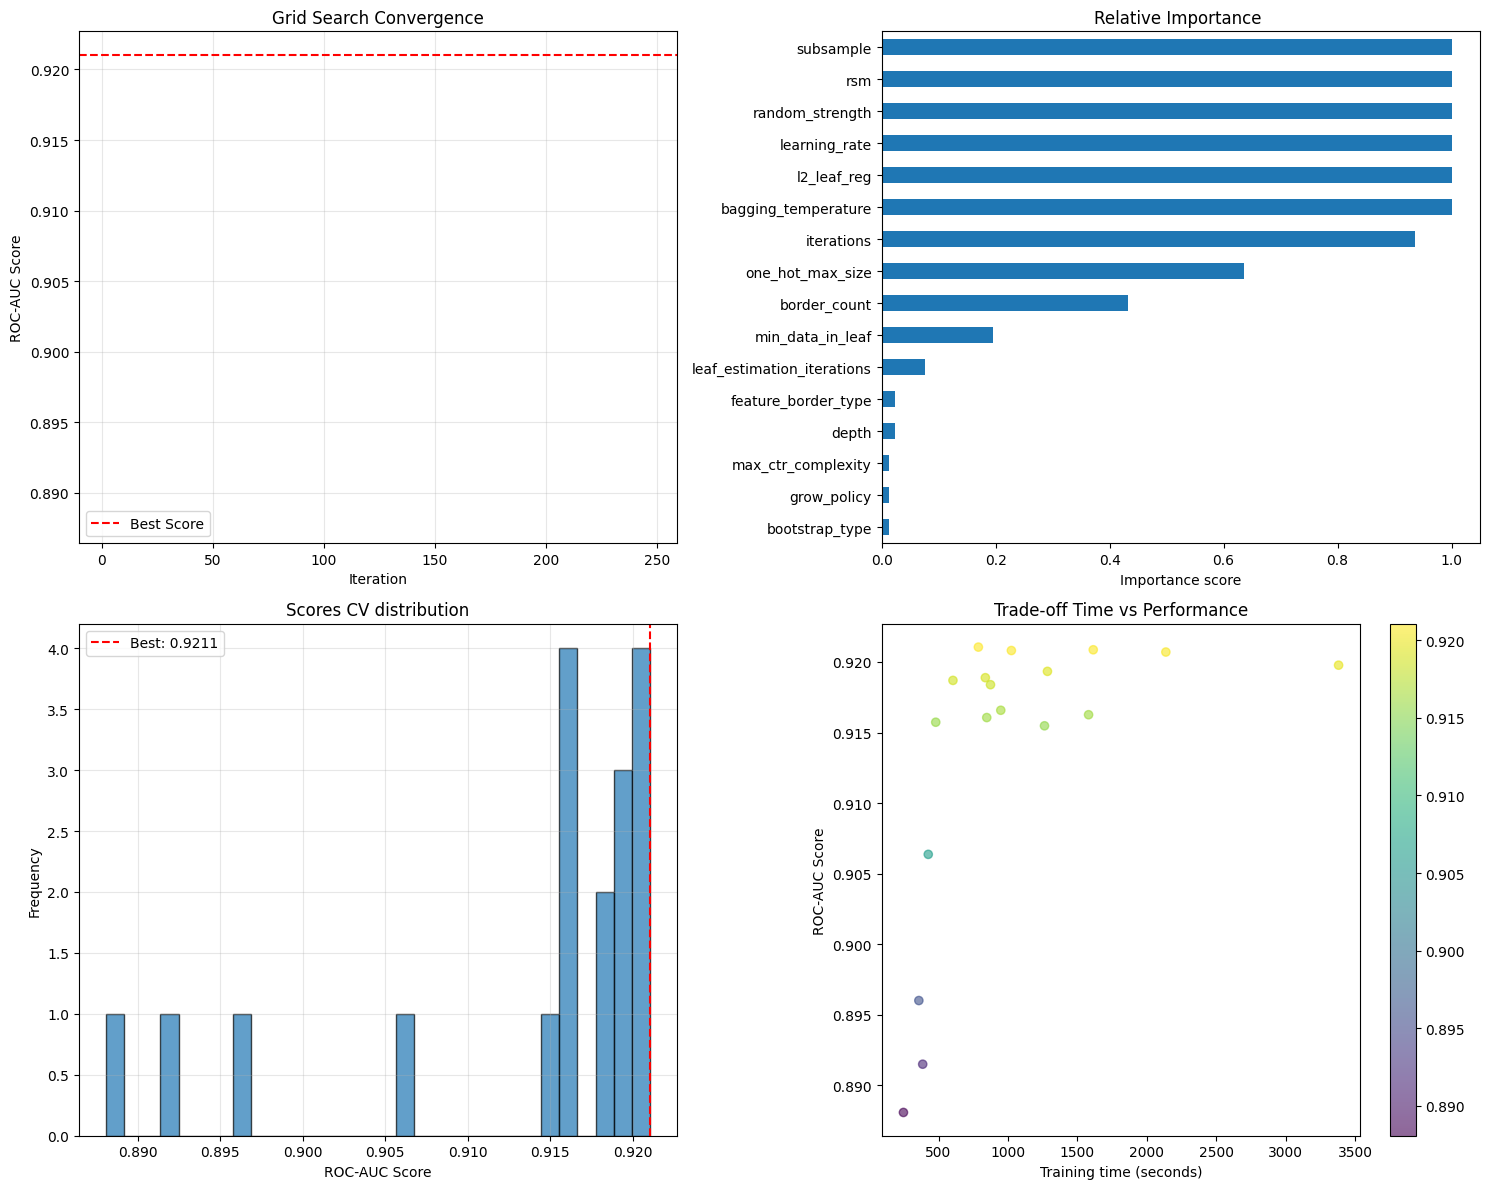


=== Finalizing model ===

Metrics on test set:
Accuracy: 0.8467
Precision: 0.8322
Recall: 0.8686
F1 Score: 0.8500
Roc Auc: 0.9208
Average Precision: 0.9165

=== Saving finalized model and scaler ===
Errore in pipeline: 'str' object has no attribute 'model_save_dir'
🏃 View run unique-hound-283 at: http://localhost:8080/#/experiments/425459300036936532/runs/205af4683dde4ed894b5f8648cf405f5
🧪 View experiment at: http://localhost:8080/#/experiments/425459300036936532


AttributeError: 'str' object has no attribute 'model_save_dir'

In [7]:
date = datetime.now().strftime("%d%m%y_%H%M")
pipeline = CatBoostPipeline(
    features_df=features_df, 
    labels_df=labels_df,
    experiment_name=f"catboost_experiment_{date}",
    model_save_dir=f"./models/catboost_run_{date}",
)

# Esegui la pipeline completa
model, best_params, run_id = pipeline.run_complete_pipeline(
    model_name=f"catboost_dev_model_{date}"
)

In [ ]:
# Finalizza il modello sui dati completi
final_model, final_scaler, final_run_id = pipeline.finalize_model(
     features_df_to_finalize=features_df_to_finalize,
     labels_df_to_finalize=labels_df_to_finalize,
     model_path="./models/catboost_run_{date}/catboost_dev_model_{date}.cbm",
     scaler_path="./models/catboost_run_{date}/catboost_dev_model_v1_scaler.joblib",
     final_model_name=f"catboost_trained_on_full_data_model_{date}",
     use_early_stopping=True
 )


In [ ]:

# ========================================
# SCENARIO 3: Predizioni con modello salvato
# ========================================

# Per predire su nuovi dati
# new_predictions, new_probabilities = pipeline.predict_new_data(new_data_df)

# Per caricare un modello salvato
# model, scaler = CatBoostPipeline.load_model_and_scaler(
#     "./my_models/production_model_v1.cbm", 
#     "./my_models/production_model_v1_scaler.joblib"
# )


